In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [6]:
# creates RNN/LSTM model that categorizes text as 'spam' or no 'spam'
# Training dataset: 3565 samples, validation: 892
# achieves 0.9817 validation accuracy with 0.0548 validation loss on the second epoch, after which it is showing signs of overfitting
# model correctly predicts spam and non-spam message with treshold of 0.3

# LSTM vs CNN on the same language task
#         ACCURACY | LOSS
#    LSTM    0.9817| 0.0548 (2nd epoch)
# .  CNN     0.9846| 0.0712 (2nd epoch)

In [7]:
EPOCHES = 10

In [8]:
# GET DATA
data = pd.read_csv('data/text/spam.csv',delimiter=',',encoding='latin-1', usecols=['v1', 'v2'])
data.head()
X = data.v2
Y = data.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [9]:
# TOKENIZE
max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [10]:
# CREATE MODEL
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
    return model

In [11]:
model = RNN()

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [13]:
# TRAIN THE MODEL
history = model.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.3,
    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3315 samples, validate on 1421 samples
Epoch 1/5
3315/3315 [==============================] - 27s 8ms/step - loss: 0.3404 - acc: 0.8612 - val_loss: 0.1827 - val_acc: 0.9177
Epoch 2/5
3315/3315 [==============================] - 47s 14ms/step - loss: 0.1010 - acc: 0.9756 - val_loss: 0.0644 - val_acc: 0.9803
Epoch 3/5
3315/3315 [==============================] - 61s 18ms/step - loss: 0.0443 - acc: 0.9864 - val_loss: 0.0548 - val_acc: 0.9817
Epoch 4/5
3315/3315 [==============================] - 58s 17ms/step - loss: 0.0299 - acc: 0.9910 - val_loss: 0.0569 - val_acc: 0.9803


In [14]:
#model.save_weights('models/rnn_text_epochs.h5') # save model

In [29]:
#PLOT ACCURACY AND LOSS
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

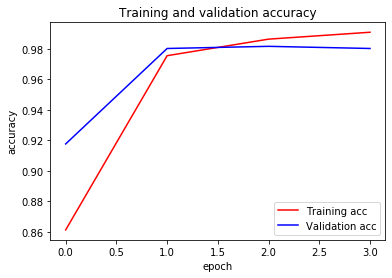

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

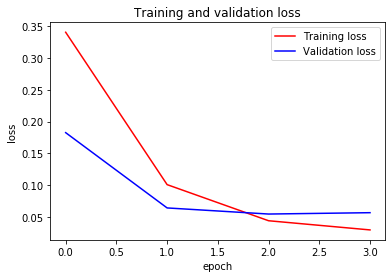

In [31]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [32]:
new_message = ['Free tickets to any concert - call us for more information.']
sequences = tokenizer.texts_to_sequences(new_message)
padded = sequence.pad_sequences(sequences, maxlen=150)
pred = model.predict(padded)
labels = ['spam', 'ham']
print(pred > 0.3, labels[np.argmax(pred)])

[[ True]] spam


In [33]:
new_message = ['howdy brother!' ]
sequences = tokenizer.texts_to_sequences(new_message)
padded = sequence.pad_sequences(sequences, maxlen=150)
pred = model.predict(padded)
labels = ['spam', 'ham']
print(pred > 0.3, labels[np.argmax(pred)])

[[False]] spam
